# Introduction

In this tutorial we create a simple model that find the average of two time series and schedule this to output to a third time series. All from within a notebook! This is of course overkill for such a simple task, but is nice and simple for an example.

**Requirements**:
- You need to have the `cognite-model-hosting-notebook` package installed
- The environment variable `COGNITE_API_KEY` should be set

# Data

You can use your own data or you can generate some fake data by running the `generate_data.py` script.

In [1]:
# The ids of the time series we will use
# NOTE: USE YOUR OWN TIME SERIES OR THOSE YOU GET FROM generate_data.py
ts_ids = {
    'x': 3141055735716788,
    'y': 2959476515512874,
    'mean_x_y': 6517783964008796,
}

Let's take a quick look at the last two hours.

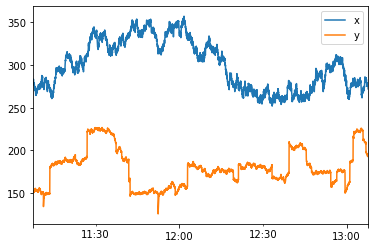

In [2]:
from cognite.model_hosting.data_fetcher import DataFetcher
from cognite.model_hosting.data_spec import DataSpec, TimeSeriesSpec

example_data_spec = DataSpec(time_series={
    "x": TimeSeriesSpec(
        id=ts_ids["x"],
        start="2h-ago",
        end="now",
        aggregate="interpolation",
        granularity="1s"
    ),
    "y": TimeSeriesSpec(
        id=ts_ids["y"],
        start="2h-ago",
        end="now",
        aggregate="interpolation",
        granularity="1s"
    ),
})

%matplotlib inline
DataFetcher(example_data_spec).time_series.fetch_dataframe(["x", "y"]).plot()

# Defining our model

First off we need to define our dependencies. This is simply achieved by creating a code cell that start with `# !requirements`. Our model will use `numpy` for calculations on arrays of numbers, so we'll be sure to add that. It's always good practice to be specific of the version of the package to avoid breaking changes in the future.

In [3]:
# !requirements
# cognite-model-hosting==0.2.0
# numpy==1.16.2

In [4]:
# !model
import numpy as np
from cognite.model_hosting.data_fetcher import DataFetcher
from cognite.model_hosting.schedules import to_output

In [5]:
# !model
def predict(instance):
    data_fetcher = DataFetcher(instance, client_name="tutorial-mean-client")
    df = data_fetcher.time_series.fetch_dataframe(["x", "y"]).dropna()
    df["mean"] = np.mean(df[["x", "y"]].values, axis=1)
    
    return to_output(df[["mean"]])

Notice that we start each cell with `# !model`. This means this code will be included in our model. The next cells below will only be for local execution, and are not supposed to be executed in Model Hosting. And thus do not start with `# !model`. For our model to work with Model Hosting we have to define a `predict()` function. It's first parameter must be `instance` - the entity on which to perform prediction on. After that we may define our own parameters. We can of course also define other functions (and classes, etc) to help us do the prediction as we have done above.

Okay, now we have defined our model. Let's try it out locally before we deploy it to Model Hosting.

In [6]:
prediction = predict(example_data_spec)

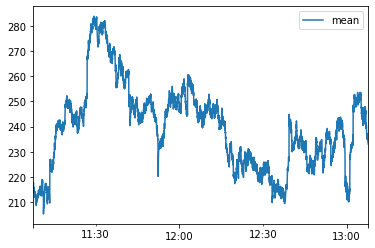

In [7]:
import pandas as pd
from cognite.model_hosting.schedules import ScheduleOutput

df = ScheduleOutput(prediction).get_dataframe("mean")
df.plot()

Looks good!

# Deploying our model

It's time to deploy our model. Let's first import what we need.

In [8]:
from cognite.client.experimental import CogniteClient
from cognite.model_hosting.notebook import deploy_model_version

model_hosting = CogniteClient().model_hosting

To deploy a model version we first need a model. Note that it's important to specify the input and output fields for a model that will be scheduled.

In [9]:
model_name = "mean-x-y"
model_hosting.models.create_model(
    model_name,
    input_fields=[
        {"name": "x", "type": "TIME_SERIES"},
        {"name": "y", "type": "TIME_SERIES"},
    ],
    output_fields=[
        {"name": "mean", "type": "TIME_SERIES"},
    ],
)

And then we deploy this notebook as a model version. It's important you **save the notebook** before doing this since the notebook file will be read to find your model.

In [10]:
model_version_name = "mean-x-y-v1"
deploy_model_version(
    model_name=model_name,
    version_name=model_version_name,
    runtime_version="0.1"
)

Now we just have to wait for the deployment to finish. This usually takes a few minutes. Notice that the next step won't work before the status of the model version is 'READY'.

In [11]:
model_hosting.versions.get_model_version(model_name, model_version_name).status

'READY'

# Testing the model

Let's test the deployed model before we schedule it

In [12]:
prediction = model_hosting.models.online_predict(
    model_name,
    model_version_name,
    instances=[example_data_spec]
)[0]

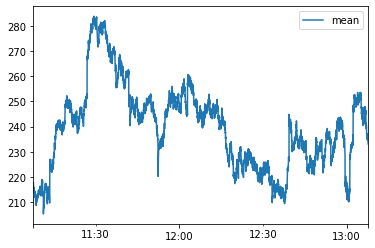

In [13]:
df = ScheduleOutput(prediction).get_dataframe("mean")
df.plot()

Same result as we got locally! It's important to note that these predictions were performed in Cognite Model Hosting in the cloud, not on your computer. Anyone with internet (and appropriate access rights) can now access this model!

# Setting up a schedule

Setting up a schedule is mostly a matter of specifying a schedule data spec. It says how often predictions should be made and how much data you will observe at once.

We will run once a minute so we set `stride="1m"`, and we don't need any kind of look-back or something like that so we also just set `window_size="1m"`. To account for data coming in a bit late we set `slack="10m"`, which tells Model Hosting to redo predictions for data being up to 10 minutes late. For input we specify our x and y time series, and specify our mean time series as output. Note that this must match with the input and output fields of the model.

In [14]:
from cognite.model_hosting.data_spec import (
    ScheduleDataSpec,
    ScheduleInputSpec,
    ScheduleOutputSpec,
    ScheduleInputTimeSeriesSpec,
    ScheduleOutputTimeSeriesSpec
)

schedule_data_spec = ScheduleDataSpec(
    stride="1m",
    window_size="1m",
    slack="10m",
    input=ScheduleInputSpec(
        time_series={
            "x": ScheduleInputTimeSeriesSpec(
                id=ts_ids["x"],
                aggregate="interpolation",
                granularity="1s"
            ),
            "y": ScheduleInputTimeSeriesSpec(
                id=ts_ids["y"],
                aggregate="interpolation",
                granularity="1s"
            )
        }
    ),
    output=ScheduleOutputSpec(
        time_series={
            "mean": ScheduleOutputTimeSeriesSpec(id=ts_ids["mean_x_y"])
        }
    )
)

schedule_name = "mean-x-y-schedule"
model_hosting.schedules.create_schedule(
    model_name=model_name,
    schedule_name=schedule_name,
    schedule_data_spec=schedule_data_spec,
    description="A cool schedule"
)

Now we just have to wait. It will run once a minute - so we'll wait a few minutes.

Once we have waited a bit we can try to download and plot the x and y time series together with our new mean time series. We'll take a look at the last 10 minutes.

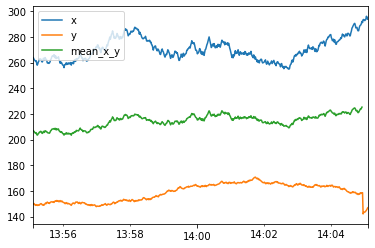

In [15]:
data_spec = DataSpec(time_series={
    "x": TimeSeriesSpec(
        id=ts_ids["x"],
        start="10m-ago",
        end="now",
        aggregate="interpolation",
        granularity="1s"
    ),
    "y": TimeSeriesSpec(
        id=ts_ids["y"],
        start="10m-ago",
        end="now",
        aggregate="interpolation",
        granularity="1s"
    ),
    "mean_x_y": TimeSeriesSpec(
        id=ts_ids["mean_x_y"],
        start="10m-ago",
        end="now",
        aggregate="interpolation",
        granularity="1s"
    ),
})
data_fetcher = DataFetcher(data_spec)
data_fetcher.time_series.fetch_dataframe(["x", "y", "mean_x_y"]).plot()

Look at it go!

This will continue to run in Model Hosting long after we shut down this notebook - 24/7.

As always - when you're done with a tutorial - remember to clean up after yourself.

In [16]:
source_package_id = model_hosting.versions.get_model_version(
    model_name,
    model_version_name
).source_package_id

# This will delete all versions and schedules for that model
model_hosting.models.delete_model(model_name)

# We also have to delete the source package
model_hosting.source_packages.delete_source_package(source_package_id)